# WorldFloods Database
[Tutorial here](http://trilliumtechnologies.net/ml4floods/content/prep/full_data_ingest.html) <br>
Coastal flood activation codes:
['EMSR419', 'EMSR422', 'EMSR438', 'EMSR249', 'EMSR260', 'EMSR348',
       'EMSR354', 'EMSR357', 'EMSR385', 'EMSR405', 'EMSR416', 'EMSR434',
       'EMSR464', 'EMSR482', 'EMSR495', 'EMSR564', 'EMSR565']

In [1]:
import sys
import os
from tqdm import tqdm

import pandas as pd

from ml4floods.data.copernicusEMS import activations
from ml4floods.data import utils
from pathlib import Path

coastal_flood_codes = ['EMSR419', 'EMSR422', 'EMSR438', 'EMSR249', 'EMSR260', 'EMSR348',
       'EMSR354', 'EMSR357', 'EMSR385', 'EMSR405', 'EMSR416', 'EMSR434',
       'EMSR464', 'EMSR482', 'EMSR495', 'EMSR564', 'EMSR565']

In [2]:
table_activations_ems = activations.table_floods_ems(event_start_date="2010-01-01")
coastal_floods = table_activations_ems[table_activations_ems.index.isin(coastal_flood_codes)]

In [3]:
code_dict = {}
for code in coastal_floods.reset_index()['Code']:
    code_dict[code] = ""

In [4]:
regions_dict = {}

for code, title in coastal_floods[['Title']].iterrows():
    regions_dict[code] = ''  # title['Title']

In [5]:
events_dict = {'EMSR565': 'emnati_madagascar',
                 'EMSR564': 'batsirai_madagascar',
                 'EMSR495': 'eloise_mozambique',
                 'EMSR482': 'iota_centralamerica',
                 'EMSR464': 'noul_vietnam',
                 'EMSR438': 'flood_uganda',
                 'EMSR434': 'harold_vanuatu',
                 'EMSR422': 'flood_mediterranean',
                 'EMSR419': 'flood_southeastiran',
                 'EMSR416': 'flood_landes',
                 'EMSR405': 'nakri_vietnam',
                 'EMSR385': 'dorian_bahamas',
                 'EMSR357': 'fani_eastindia',
                 'EMSR354': 'kenneth_cabodelgado',
                 'EMSR348': 'idai_mozambique',
                 'EMSR260': 'flood_northitaly',
                 'EMSR249': 'ophelia_ireland'}

In [6]:
i = 11

emsr_code = coastal_floods.reset_index()['Code'][i]
event = events_dict[emsr_code]
zip_files_activation_url_list = activations.fetch_zip_file_urls(emsr_code)
zip_files_activation_url_list

['https://emergency.copernicus.eu/mapping/download/176419/EMSR385_AOI15_GRA_PRODUCT_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176088/EMSR385_AOI05_GRA_PRODUCT_r1_VECTORS_v3_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176084/EMSR385_AOI05_GRA_PRODUCT_r1_RTP03_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176083/EMSR385_AOI05_GRA_PRODUCT_r1_RTP02_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176043/EMSR385_AOI12_GRA_PRODUCT_r1_VECTORS_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176050/EMSR385_AOI13_GRA_PRODUCT_r1_RTP02_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176047/EMSR385_AOI14_GRA_PRODUCT_r1_RTP02_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176048/EMSR385_AOI14_GRA_PRODUCT_r1_VECTORS_v2_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/176053/EMSR385_AOI13_GRA_PRODUCT_r1_VECTORS_v2_vector.zip',
 'https:/

In [7]:
folder_out = os.path.join('..', 'data', 'copernicus_raw')
os.makedirs(folder_out, exist_ok=True)

unzip_files_activation = []
for zip_file in tqdm(zip_files_activation_url_list):
    local_zip_file = activations.download_vector_cems(zip_file, 
                                                      folder_out=folder_out)
    unzipped_file = activations.unzip_copernicus_ems(local_zip_file,
                                                     folder_out=folder_out)
    unzip_files_activation.append(unzipped_file)

100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1619.74it/s]

	File https://emergency.copernicus.eu/mapping/download/176419/EMSR385_AOI15_GRA_PRODUCT_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/176088/EMSR385_AOI05_GRA_PRODUCT_r1_VECTORS_v3_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/176084/EMSR385_AOI05_GRA_PRODUCT_r1_RTP03_v2_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/176083/EMSR385_AOI05_GRA_PRODUCT_r1_RTP02_v2_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/176043/EMSR385_AOI12_GRA_PRODUCT_r1_VECTORS_v2_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/176050/EMSR385_AOI13_GRA_PRODUCT_r1_RTP02_v2_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/176047/EMSR385_AOI14_GRA_PRODUCT_r1_RTP02_v2_vector.zip already exists. Not downloaded


In [8]:
# folder_out=f"Copernicus_EMS_raw/{activation}"
code_date = table_activations_ems.loc[emsr_code]["CodeDate"]

registers = []
for unzip_folder in unzip_files_activation:
    metadata_floodmap = activations.filter_register_copernicusems(unzip_folder, code_date)
    if metadata_floodmap is not None:
        # processes all shapefiles into a single floodmap
        floodmap = activations.generate_floodmap(metadata_floodmap, folder_files=unzip_folder)
        registers.append({"metadata_floodmap": metadata_floodmap, "floodmap": floodmap})
        print(f"File {unzip_folder} processed correctly")
    else:
        print(f"File {unzip_folder} does not follow the expected format. It won't be processed")

File ../data/copernicus_raw/EMSR385_AOI15_GRA_PRODUCT_r1_VECTORS_v1_vector processed correctly
File ../data/copernicus_raw/EMSR385_AOI05_GRA_PRODUCT_r1_VECTORS_v3_vector does not follow the expected format. It won't be processed
File ../data/copernicus_raw/EMSR385_AOI05_GRA_PRODUCT_r1_RTP03_v2_vector processed correctly
File ../data/copernicus_raw/EMSR385_AOI05_GRA_PRODUCT_r1_RTP02_v2_vector processed correctly
Multiple event types within shapefile ['Chemical spill' 'Coastal flood']
File ../data/copernicus_raw/EMSR385_AOI12_GRA_PRODUCT_r1_VECTORS_v2_vector processed correctly
*_observed*.shp not found in directory ../data/copernicus_raw/EMSR385_AOI13_GRA_PRODUCT_r1_RTP02_v2_vector
File ../data/copernicus_raw/EMSR385_AOI13_GRA_PRODUCT_r1_RTP02_v2_vector does not follow the expected format. It won't be processed
*_observed*.shp not found in directory ../data/copernicus_raw/EMSR385_AOI14_GRA_PRODUCT_r1_RTP02_v2_vector
File ../data/copernicus_raw/EMSR385_AOI14_GRA_PRODUCT_r1_RTP02_v2_vecto

## Sub floodmaps

In [9]:
def generate_floodfiles(event, registers):
    event_dir = os.path.join('..', 'data', 'copernicus_raw', event)
    os.makedirs(event_dir, exist_ok=True)

    # initialise with first floodmap
    j = 0
    floodmap = registers[j]['floodmap']
    metadata_floodmap = registers[j]['metadata_floodmap']

    flood = floodmap[floodmap['source'] == 'flood']
    flood['obj_desc'] = [metadata_floodmap['event type']] * len(flood)
    flood['acq_date'] = [metadata_floodmap['satellite date']] * len(flood)
    flood['satellite'] = [metadata_floodmap['satellite']] * len(flood)

    hydrographyL = floodmap[floodmap['source'] == 'hydro_l']
    hydrographyA = floodmap[floodmap['source'] == 'hydro']

    floods = [flood]
    hydrographyLs = [hydrographyL]
    hydrographyAs = [hydrographyA]
    
    # add all the other floodmaps
    for j in range(1, len(registers)):
        floodmap = registers[j]['floodmap']
        metadata_floodmap = registers[j]['metadata_floodmap']

        flood_j = floodmap[floodmap['source'] == 'flood']
        flood_j['obj_desc'] = [metadata_floodmap['event type']] * len(flood_j)
        flood_j['acq_date'] = [metadata_floodmap['satellite date']] * len(flood_j)
        flood_j['satellite'] = [metadata_floodmap['satellite']] * len(flood_j)

        hydrographyL_j = floodmap[floodmap['source'] == 'hydro_l']
        hydrographyA_j = floodmap[floodmap['source'] == 'hydro']

        floods.append(flood_j)
        hydrographyLs.append(hydrographyL_j)
        hydrographyAs.append(hydrographyA_j)

    # concatenate all the floodmaps etc.
    flood = pd.concat(floods)
    hydrographyL = pd.concat(hydrographyLs)
    hydrographyA = pd.concat(hydrographyAs)

    # save to local machine
    flood = flood[flood['obj_desc'] == 'Coastal flood']  # make sure only coastal floods
    flood['acq_date'] = flood['acq_date'].astype(str)    # otherwise fiona complains
    
    # split based-on acquisition date
    acq_dates = [*set(flood.acq_date.values)]
    for i, acq_date in enumerate(acq_dates):
        flood_i = flood[flood.acq_date == acq_date]
        flood_i.to_file(os.path.join(event_dir, f'flood_{i}.gpkg'))

    hydrographyL.to_file(os.path.join(event_dir, f'hydrographyL.gpkg'))
    hydrographyA.to_file(os.path.join(event_dir, f'hydrographyA.gpkg'))

In [10]:
generate_floodfiles(event, registers)

/Users/alison/miniconda3/envs/worldfloods/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alison/miniconda3/envs/worldfloods/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alison/miniconda3/envs/worldfloods/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to b

In [11]:
event

'dorian_bahamas'

In [ ]:
# Now loop through everything
# 13 (kenneth_cabodelgado) didn't work
# for i in range(14, len(coastal_floods)):
i = 11

emsr_code = coastal_floods.reset_index()['Code'][i]
event = events_dict[emsr_code]
zip_files_activation_url_list = activations.fetch_zip_file_urls(emsr_code)
zip_files_activation_url_list

folder_out = os.path.join('..', 'data', 'copernicus_raw')
os.makedirs(folder_out, exist_ok=True)

unzip_files_activation = []
for zip_file in tqdm(zip_files_activation_url_list):
    local_zip_file = activations.download_vector_cems(zip_file, 
                                                      folder_out=folder_out)
    unzipped_file = activations.unzip_copernicus_ems(local_zip_file,
                                                     folder_out=folder_out)
    unzip_files_activation.append(unzipped_file)

# folder_out=f"Copernicus_EMS_raw/{activation}"
code_date = table_activations_ems.loc[emsr_code]["CodeDate"]

registers = []
for unzip_folder in unzip_files_activation:
    metadata_floodmap = activations.filter_register_copernicusems(unzip_folder, code_date)
    if metadata_floodmap is not None:
        # processes all shapefiles into a single floodmap
        floodmap = activations.generate_floodmap(metadata_floodmap, folder_files=unzip_folder)
        registers.append({"metadata_floodmap": metadata_floodmap, "floodmap": floodmap})
        print(f"File {unzip_folder} processed correctly")
    else:
        print(f"File {unzip_folder} does not follow the expected format. It won't be processed")

generate_floodfiles(event, registers)

In [14]:
emsr_code

'EMSR385'

In [15]:
coastal_floods

,Title,CodeDate,Type,Country
Code,,,,
EMSR565,Tropical Cyclone Emnati in Madagascar,2022-02-22,Storm,Madagascar
EMSR564,Tropical Cyclone Batsirai in Madagascar,2022-02-05,Storm,Madagascar
EMSR495,"Tropical cyclone Eloise in Mozambique,...",2021-01-22,Storm,"Mozambique, Eswatini, Zimbabwe"
EMSR482,Tropical Cyclone Iota in Central America,2020-11-17,Storm,"Guatemala, Honduras, Nicaragua"
EMSR464,Tropical cyclone Noul in Vietnam,2020-09-18,Storm,Vietnam
EMSR438,Flood in Uganda,2020-05-09,Flood,Uganda
EMSR434,Tropical Cyclone HAROLD in Vanuatu,2020-04-06,Storm,Vanuatu
EMSR422,"Floods in Girona and Mediterranean coast,...",2020-01-23,Flood,Spain
EMSR419,Flood in South East Iran,2020-01-13,Flood,Iran


# Plot the flood

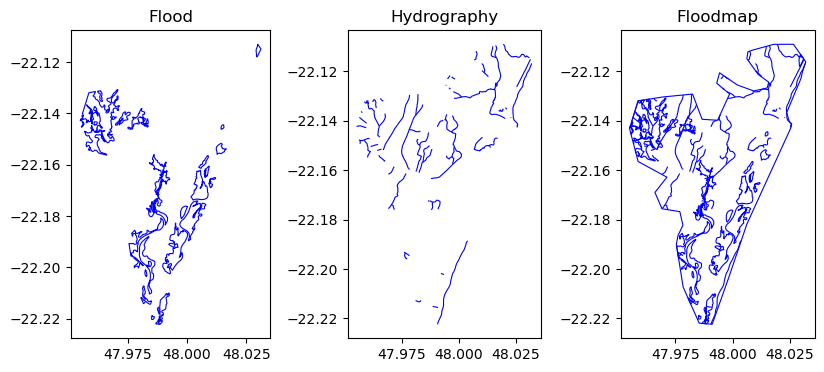

In [37]:
import matplotlib.pyplot as plt

# initialize figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

ax = axs[0]
floodmap[floodmap["source"] == "flood"].plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)
ax.set(
    title="Flood"
)


ax = axs[1]
floodmap[floodmap["source"] == "hydro_l"].plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)
ax.set(
    title="Hydrography"
)

ax = axs[2]
floodmap[floodmap["source"] != "hydro"].plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)
ax.set(
    title="Floodmap"
);

In [39]:
metadata_floodmap

{'event id': 'EMSR565_AOI03_GRA_PRODUCT',
 'layer name': 'EMSR565_AOI03_GRA_PRODUCT_observedEventA_r1_v1',
 'event type': 'Coastal flood',
 'satellite date': Timestamp('2022-03-01 07:15:35+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'Pleiades-1A-1B',
 'bounding box': {'west': 47.95507853600003,
  'east': 48.031119337000064,
  'north': -22.11309003799994,
  'south': -22.222189589999967},
 'reference system': 'epsg:4326',
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x13568a9e0>,
 'observed_event_file': 'EMSR565_AOI03_GRA_PRODUCT_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'EMSR565_AOI03_GRA_PRODUCT_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR565',
 'aoi_code': 'AOI03',
 'date_ems_code': datetime.datetime(2022, 2, 22, 0, 0, tzinfo=datetime.timezone.utc),
 'satellite_pre_event': 'Open Street Map',
 'timestamp_pre_event': Timestamp('2022-02-23 00:00:00+0000', tz='UTC'),
 'hydrology_fil

## Visualise with Google Earth Engine, later

In [21]:
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from ml4floods.data import ee_download, create_gt
from shapely.geometry import mapping

In [22]:
!earthengine authenticate

Fetching credentials using gcloud
Traceback (most recent call last):
  File "/Users/alison/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/ee/oauth.py", line 291, in _load_app_default_credentials
    subprocess.run(command, check=True)
  File "/Users/alison/miniconda3/envs/hybridmodels/lib/python3.10/subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/Users/alison/miniconda3/envs/hybridmodels/lib/python3.10/subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/Users/alison/miniconda3/envs/hybridmodels/lib/python3.10/subprocess.py", line 1847, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'gcloud'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/alison/miniconda3/envs/hybridmodels/bin/earthengine", line 10, in <module>


In [23]:
ee.Initialize()

bounds_pol = activations.generate_polygon(metadata_floodmap["area_of_interest_polygon"].bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

pol = ee.Geometry(mapping(metadata_floodmap["area_of_interest_polygon"]))

date_event = datetime.utcfromtimestamp(metadata_floodmap["satellite date"].timestamp())

date_end_search = date_event + timedelta(days=20)

# Grab the S2 images and the Permanent water image
img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)
permanent_water_img = ee_download.permanent_water_image(date_event.year, pol_2_clip)


# Get info of the Image Collection (convert to table)
img_col_info = ee_download.img_collection_to_feature_collection(img_col,
                                                               ["system:time_start", "valids", "cloud_probability"])
img_col_info_local = gpd.GeoDataFrame.from_features(img_col_info.getInfo())
img_col_info_local["system:time_start"] = img_col_info_local["system:time_start"].apply(lambda x: datetime.utcfromtimestamp(x/1000))

n_images_col = img_col_info_local.shape[0]
print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")

# Plot images using geemap
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    img_show = ee.Image(imgs_list.get(i))
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000, 
                  "bands":["B4","B3","B2"]},
                 f"({i}/{n_images_col}) S2 RGB {img_col_info_local['system:time_start'][i].strftime('%Y-%m-%d')}", 
                 False)
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000, 
                  "bands":["B11","B8","B4"]},
                 f"({i}/{n_images_col}) S2 SWIR/NIR/RED {img_col_info_local['system:time_start'][i].strftime('%Y-%m-%d')}", 
                 True)

# Viz permanent water layer
visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(permanent_water_img, visualization, name="JRC Permanent water")


floodmap_folium = folium.features.GeoJson(floodmap, name="FloodMap")
Map.add_child(floodmap_folium,name="FloodMap")

# Map.addLayer(pol, {"color": 'FF000000'}, "AoI")

Map.centerObject(pol, zoom=10)
folium.LayerControl(collapsed=False).add_to(Map)
Map

EEException: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, and then retry.